<img src="dd_logo.png" />

# Welcome to the Datadog APM workshop! 

Today we'll be walk through use cases of tracing, and see how you can incorporate it into your infrastructure.

The standards around tracing are still being worked on, and you should be a part of determining its direction. 

**If while working with APM you have a suggestion for improvement, or get stuck, please don't hesitate to reach out to someone at Datadog.** 

You can do so via our APM community Slack channel. We're here to make things easier for you and your team.

If you don't feel comfortable asking it in the (mostly) public forum of our chatroom, feel free to reach out to me on Twitter [@burningion](https://twitter.com/burningion).

## Before We Begin

In order to run through the second part of this walkthrough, you'll need to download some docker images.

Wifi at events tends to be tricky, so it's probably best if you clone the following repo, and do a `docker-compose` up while we go over the introduction:

```bash
git clone https://github.com/burningion/dash-apm-workshop
cd dash-apm-workshop
!DD_API_KEY=fff STEP=1 docker-compose up
```

You'll also need to create a Datadog account, but that's something we'll do in the second part of the workshop. (After we go over tracing at a high level, and send some traces from the command line.)

# Overview: Tracing

## What is Tracing?

*Tracing is a method for debugging distributed systems.* 

It's a way to see a single transaction or workflow as it travels across all systems, with structured data about what happened where.

Tracing does this by creating a series of spans, representing details of what happens at every point in a system, and keeping track of the relationships of these spans.

It differs from *logging* in that it keeps structured versions of your data. It keeps track of a single request or unit of work as it passes through your whole system.

Imagine you were building the results page for a search engine. 

Your endpoint has to call services for images, videos, advertising, and relevant search results themselves. This request may happen across hundreds of servers.

Tracing allows you to unify each of these search as a single trace, and see the entire flow through complex systems. By unifying the request as it processes through the system, you can see exactly where things go wrong, in production, with real traffic.

## How is it implemented?

Tracing is done via either black-box or annotation-based monitoring.

In our case, we're using annotation-based monitoring. This means we need to instrument all of our code with custom spans, allowing us to see requests as they propagate through our systems.

Usually, we can get by with just instrumenting the most critical libraries within our applications. For example, we'd instrument the RPC, web frameworks, and database interfaces. Datadog does this automatically with many major libraries, services, and languages.

With these, we can then add service level spans that make sense to keep track of in a distrubuted system. This may be things like transaction ids, search requests, etc.

The single trace, and set of spans form a tree, and allow us to recreate the flow through our distributed system.

## What are the Standards?

Right now, the [CNCF](https://www.cncf.io/) is developing a standard called [OpenTracing](http://opentracing.io/). It gives a base set of implementations in different programming languages, along with a set of [semantic conventions](https://github.com/opentracing/specification/blob/master/semantic_conventions.md) that set a standard for all the standard implementors to adhere to.

So OpenTracing creates a library called [OpenTracing Python](https://github.com/opentracing/opentracing-python), and it's up to vendors like [Datadog](https://www.datadoghq.com) to implement the shipping portion of them.

Besides OpenTracing, Google has started work on [OpenCensus](https://opencensus.io/), another implementation of tracing.

Datadog has support for both standards, and is working to support more languages / implementations. 

Ideally, the singleton which sends and receives traces and spans is swappable, and the code for instrumenting your service stays the same.

## What are the Use Cases?

Tracing is another tool for working with distributed systems. It's part of a complete suite of tools that allow large teams to continually deploy, improve, and recover from errors.

For example:

* **long tail latency** - See which requests on your servers take the longest, and where
* **service dependencies** - What other services does your microservice rely on?
* **modeling network usage** - Get a feel for how scaling your services will affect others
* **firefighting** - Quickly diagnose where things may be going wrong in production
* **debugging batch workloads** - See the exact jobs that break your batch workloads, and where

The Google paper on their internal tracer [Dapper](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/36356.pdf) provides more context, in their distributed environment.

Google's [Site Reliability Engineering](https://landing.google.com/sre/book.html) also has a ton of great use cases and recommendations for tracers.

## How do I get started with my organization?

Might put together a demo either using Datadog trial, or something like Jaeger / Zipkin. If existing Datadog user, showcase having all monitoring & logging in one place.

Are you currently evaluating APM / tracing? Already implemented? Stopped using?

Who is working with distributed systems in their organization? Show of hands? How do you manage deployments? What about outages?

**Languages we support goes here, possibly a table**

**Ease of Tracing w/ Datadog**

## Tracing Terminology

* **trace** - the graph of all spans in a single unit of work
* **span** - single operation with/without child and/or parent process
* **tag** - metadata attached to span
* **sampling** - how spans and traces are sampled / kept
* **tracer** - singleton object that handles all traces / spans



# Tracing with APM Quickstart

Most of this quick start guide is based upon the great [opentracing tutorial](https://github.com/yurishkuro/opentracing-tutorial/tree/master/python) by [Yuri Shkuro](https://github.com/yurishkuro). Feel free to reference his repo to learn more about tracing with OpenTracing in Python.

There's also a [Katakoda lesson](https://www.katacoda.com/courses/opentracing) that follows the tutorial, if you don't want to install and setup Docker on your local system just yet.

In order to run through this Quickstart, you'll need to have [Docker](https://www.docker.com/) installed on your local machine, along with Python 3 and the [Jupyter notebook](http://jupyter.org/). You should be able to install Jupyter with a `pip install jupyter`. 

Switch the directory this notebook is in, and run `jupyter notebook`.

Once that's all setup, we'll use Docker images to interactively see how Jaeger is working.

## Running the Datadog Agent Container

First things first, we'll use Jupyter notebook's `!` command, to spin up our Docker image:

In [ ]:
!docker run -e DD_API_KEY=<YOUR API KEY> -e DD_APM_ENABLED=true -p8126:8126 datadog/agent:6.2.1

Alternately, you can open up a bash terminal, and type in the following:

```bash
$ docker run -e DD_API_KEY=<YOUR API KEY> -e DD_APM_ENABLED=true -p8126:8126 datadog/agent:6.2.1
```

Either way, once Docker downloads your image, you should be see logs that the agent is succesfully posting payloads.

We're now ready to start shipping our first traces.

## Installing A Tracing Library for Python

With the Agent now running, we've now got a place to ship our traces to. We'll now need to set up Python to be able to ship traces.

For our example, we'll start with the [dd-trace-py](https://github.com/DataDog/dd-trace-py) library. The binding is installable with `pip`.

In [ ]:
!pip3 install ddtrace

>**Wait, why am I not installing something like opentracing-python?!**

>[opentracing-python](https://github.com/opentracing/opentracing-python) is just a reference API. It's an empty shell if you will, that each OpenTracing platform must then implement themselves. Changing platforms should just mean changing the initialization of your `tracer` object, and the rest of your code should stay the same.

## Configuring the Tracer

Now we have a way to ship our Traces from Python, and can jump in and configure a program to be instrumented.

Let's do that now. We'll initialize and configure Jaeger's Python bindings to ship to our local Docker container:

In [ ]:
from ddtrace import tracer

# by default, localhost and 8126, but here as intructional
tracer.configure(hostname='localhost', port='8126')

## Creating Our First Span

With our new `tracer`, we can now ship our first trace, using a context:

In [ ]:
# needed to sleep
import time

# set the span name, and the service name
with tracer.start_span('first-span', service='first-service') as span:
    time.sleep(.5)

Typing these lines into the iPython session, we should then see a line that says the span is being reported. 

One important note here, the tracer **does not** flush immediately. If you were to run this in a program, it might exit before the tracer gets a chance to flush, and may not actually end up sending your trace.

In most web / API applications, this shouldn't matter, as your program will be long running. But if you're trying to trace a smaller application, it helps to be aware of this caveat.

Next, we can reload the [Jaeger page](http://localhost:16686/search), and see our service in the list of services, along with the trace and span. You may need to click the `Find Traces` button to see your traces.

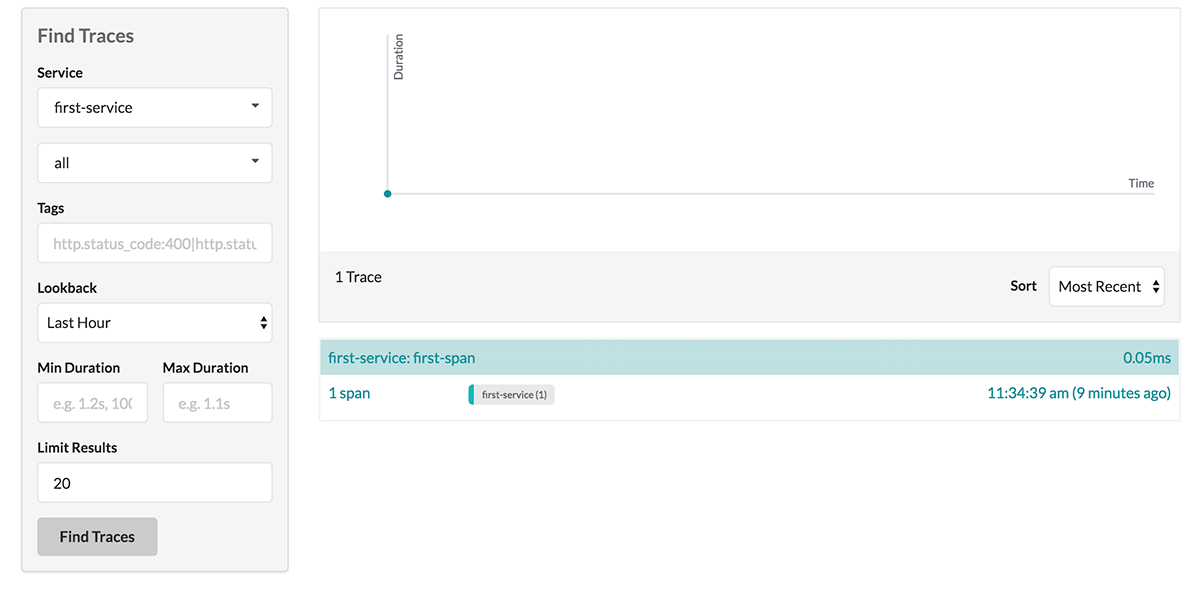

If we click on the span itself, we can see more information. Drilling down further, we can see the tag we set:

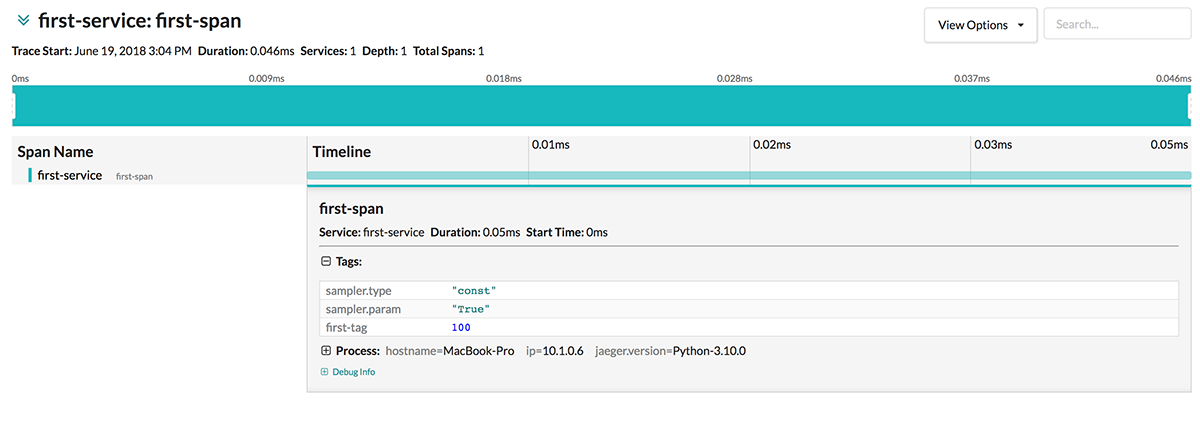

Notice that our tag we set is visible under the span. This is a good place to put debug information you may want to use to correlate to what's happening.

# Creating A Child Span 

Creating a child is done by creating tracer span as a `child_of` the parent span. Let's try that now, and see how it changes our `span`s in Jaeger:

In [ ]:
with tracer.start_span('second-span') as span2:
    span2.set_tag('second-tag', '200')
    with tracer.start_span('third-span', child_of=span2) as span3:
        span3.set_tag('third-tag', '300')


After running this code in our `ipython` repl, we can now go into Jaeger, and see our `fifth-span` successfully made a child of `fourth-span`. 

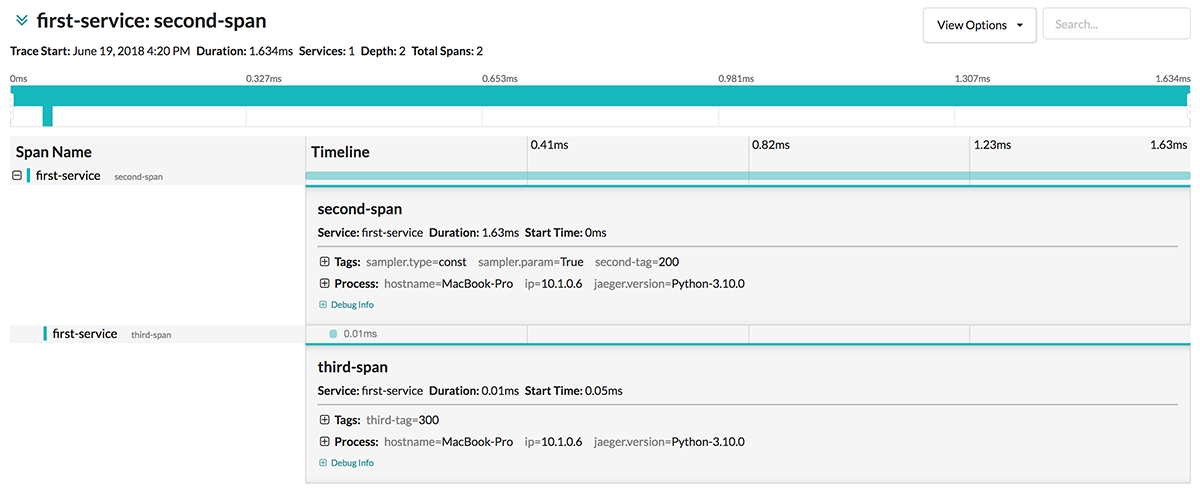

Try putting some delays between our spans to see how this affects your timeline. You'll start to get a feel for how spans show different delays of time.

## Tracing a HTTP Requests

Tracing is most useful when we get to see what's going on in our systems. Let's do two HTTP requests that rely on each other, and see how tracing allows us to visualize the process.

We'll use the `requests` library to do some HTTP GETs on the [Github jobs API](https://jobs.github.com/api). If you don't have `requests` installed, you can run the following command to get it installed via pip:


In [ ]:
!pip install requests

Next, let's try running a request to get a list of the first 50 Python jobs, and then try grabbing each job listing's company site:

In [ ]:
import requests
with tracer.start_span('get-python-jobs') as span:
    homepages = []
    res = requests.get('https://jobs.github.com/positions.json?description=python')
    span.set_tag('jobs-count', len(res.json()))
    for result in res.json():
        with tracer.start_span(result['company'], child_of=span) as site_span:
            print('Getting website for %s' % result['company'])
            try:
                res = requests.get(result['company_url'])
                homepages.append(res)
                site_span.set_tag('http.status_code', res.status_code)
            except Exception as err:
                print('Unable to get site for %s' % result['company'])
                site_span.set_tag('error', 'true')
                site_span.log_event(event='error')
                site_span.log_event(event='error.object', payload=err)

If you were paying attention, you saw the new spans we created. 

One span encapsulates the job of getting the initial API request, and a new span is created for each request attempting to grab the homepage of a job's company.

If we go into the Jaeger dashboard, we can see the requests, along with their information:

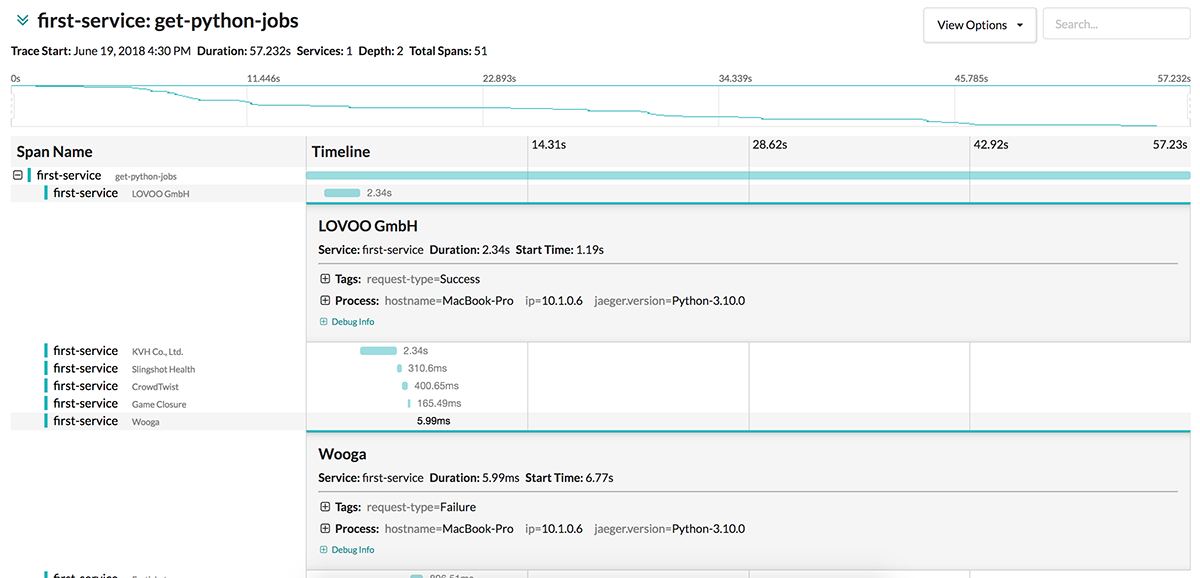

Looking here, we can see which company website is slowest to be fetched, and which is fastest. Which company would you rather be on? The one with the slow corporate site, or the fast one? 

## Automatic Instrumentation

Because the `requests` library is one of the automatic libraries provided by Datadog, we can instrument using that.

Our code from before becomes: